# 数据读取与划分

- 读取 `FS_Preprocessed.xlsx`
- 以 2015-2022 为训练集，2023-2025 为测试集
- 输出舞弊占比，后续准备不平衡处理

In [1]:
import pandas as pd
from pathlib import Path

data_path = Path("FS_Preprocessed.xlsx")
if not data_path.exists():
    raise FileNotFoundError(f"未找到文件: {data_path.resolve()}")

df = pd.read_excel(data_path)

print("数据形状:", df.shape)
print("列名示例:", df.columns[:8].tolist())
print("年份范围:", df["年份"].min(), "-", df["年份"].max())
print("舞弊样本数:", int(df["是否舞弊"].sum()))
print("舞弊比例: {:.2%}".format(df["是否舞弊"].mean()))

数据形状: (267302, 109)
列名示例: ['证券代码', '证券简称', '统计截止日期', '年份', '是否舞弊', '流动资产比率', '现金资产比率', '应收类资产比率']
年份范围: 2015 - 2025
舞弊样本数: 6842
舞弊比例: 2.56%


In [2]:
# 按年份划分训练/测试集
train_df = df[df["年份"].between(2015, 2022, inclusive="both")].copy()
test_df = df[df["年份"].between(2023, 2025, inclusive="both")].copy()
remainder_df = df[~df.index.isin(train_df.index) & ~df.index.isin(test_df.index)].copy()

def show_stats(name, data):
    total = len(data)
    fraud = int(data["是否舞弊"].sum()) if total > 0 else 0
    rate = fraud / total if total > 0 else 0
    print(f"{name}: n={total}, fraud={fraud} ({rate:.2%})")
    if total > 0:
        year_counts = data.groupby("年份")["是否舞弊"].agg(["count", "sum"])
        year_counts.rename(columns={"count": "样本数", "sum": "舞弊数"}, inplace=True)
        print(year_counts)
    print("-")

print("=== 数据切分 ===")
show_stats("Train 2015-2022", train_df)
show_stats("Test 2023-2025", test_df)
if len(remainder_df) > 0:
    show_stats("未纳入(其他年份)", remainder_df)


=== 数据切分 ===
Train 2015-2022: n=190118, fraud=6218 (3.27%)
        样本数  舞弊数
年份              
2015  15437  398
2016  17591  618
2017  23656  908
2018  23276  858
2019  24260  872
2020  27906  964
2021  28956  916
2022  29036  684
-
Test 2023-2025: n=77184, fraud=624 (0.81%)
        样本数  舞弊数
年份              
2023  30709  452
2024  29906  163
2025  16569    9
-


In [3]:
# 不平衡处理准备：特征/标签拆分 + 类别权重
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

info_cols = ["证券代码", "证券简称", "统计截止日期", "年份", "是否舞弊"]
feature_cols = [c for c in df.columns if c not in info_cols]

X_train = train_df[feature_cols].copy()
y_train = train_df["是否舞弊"].copy()
X_test = test_df[feature_cols].copy()
y_test = test_df["是否舞弊"].copy()

classes = np.array([0, 1])
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = dict(zip(classes, class_weights))
print("class_weight 可用于支持的模型 (如 LogisticRegression, RandomForest):", class_weight)

# 如需上采样示例（运行前请确认已安装 imbalanced-learn）：
try:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print(f"SMOTE 后样本数: {len(X_resampled)}, 舞弊比例: {y_resampled.mean():.2%}")
except ImportError:
    print("如需 SMOTE 上采样，请先 pip install imbalanced-learn")

class_weight 可用于支持的模型 (如 LogisticRegression, RandomForest): {np.int64(0): np.float64(0.5169059271343122), np.int64(1): np.float64(15.287713091026053)}
SMOTE 后样本数: 367800, 舞弊比例: 50.00%


In [4]:
# 欠采样：RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print("欠采样后样本数:", len(X_rus))
print("舞弊比例: {:.2%}".format(y_rus.mean()))
print("各类数量:")
print(y_rus.value_counts())

欠采样后样本数: 12436
舞弊比例: 50.00%
各类数量:
是否舞弊
0    6218
1    6218
Name: count, dtype: int64


# LightGBM 模型构建与调参

- 以召回率(Recall)最大化为目标
- 使用网格搜索(GridSearchCV)自动调参
- 参数范围参考经典文献设置

In [5]:
# 导入必要的库
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.metrics import precision_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

print("LightGBM 版本:", lgb.__version__)

LightGBM 版本: 4.6.0


In [6]:
# 使用论文给定的固定参数直接训练（跳过网格搜索）
fixed_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'max_depth': 10,
    'num_leaves': 40,
    'min_child_samples': 18,
    'min_child_weight': 0.001,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'reg_alpha': 0.02,
    'reg_lambda': 2,
    'learning_rate': 0.005,
    'n_estimators': 500,
    'verbose': -1,
    'random_state': 42
}

# 初始化模型（不再执行网格搜索）
best_model = lgb.LGBMClassifier(**fixed_params)
print("使用论文参数训练，不执行网格搜索。")

使用论文参数训练，不执行网格搜索。


In [7]:
# 使用欠采样后的数据进行训练（也可以使用原始数据或SMOTE数据）
# 选择使用哪个数据集：
# 1. X_train, y_train (原始训练数据)
# 2. X_resampled, y_resampled (SMOTE上采样)
# 3. X_rus, y_rus (欠采样)

# 这里我们使用欠采样数据
X_train_final = X_rus
y_train_final = y_rus

print("训练数据形状:", X_train_final.shape)
print("训练数据舞弊比例: {:.2%}".format(y_train_final.mean()))

训练数据形状: (12436, 104)
训练数据舞弊比例: 50.00%


In [8]:
# 直接使用论文参数训练模型
import time

print("开始训练 LightGBM（论文参数）...")
start_time = time.time()
best_model.fit(X_train_final, y_train_final)
elapsed_time = time.time() - start_time

print("训练完成。")
print(f"耗时: {elapsed_time/60:.2f} 分钟")

开始训练 LightGBM（论文参数）...
训练完成。
耗时: 0.05 分钟


# 按论文参数范围的小网格调参
- 范围依据文献：max_depth 6-20、num_leaves 40-4096、min_child_samples 18-22、min_child_weight 0.001-0.002、feature_fraction 0.6-1.0、bagging_fraction 0.8-1.0、bagging_freq 2-5、reg_alpha 0.001-0.02、reg_lambda 2-8、learning_rate 0.005-0.02、n_estimators 200-500。
- 这里提供一个“精简网格”示例，取每个区间的代表点，避免耗时过长。
- 想运行调参时，把下方 `enable_tuning` 设为 `True`；若想用调参结果参与后续评估，再把 `use_tuned_for_evaluation` 设为 `True`。

In [9]:
# 可选小网格调参：默认不运行，需手动打开
from sklearn.model_selection import GridSearchCV

enable_tuning = False  # 若要调参，将此改为 True

# 精简网格（每个参数取少量代表值，来自论文范围）
tuning_param_grid = {
    'max_depth': [8, 14, 20],
    'num_leaves': [64, 256, 1024],
    'min_child_samples': [18, 22],
    'min_child_weight': [0.001, 0.002],
    'feature_fraction': [0.6, 0.9, 1.0],
    'bagging_fraction': [0.8, 1.0],
    'bagging_freq': [2, 5],
    'reg_alpha': [0.001, 0.02],
    'reg_lambda': [2, 8],
    'learning_rate': [0.005, 0.01, 0.02],
    'n_estimators': [300, 500]
}

# 基础模型（带类权重），以 Recall 为评分
tuning_model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    class_weight=class_weight,
    random_state=42,
    verbose=-1
)

if enable_tuning:
    tuner = GridSearchCV(
        estimator=tuning_model,
        param_grid=tuning_param_grid,
        scoring='recall',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    print("开始小网格调参（可能仍需一定时间）...")
    tuner.fit(X_train_final, y_train_final)
    best_model_tuned = tuner.best_estimator_
    print("调参完成，最佳参数和召回率：")
    print(tuner.best_params_)
    print(f"best recall: {tuner.best_score_:.4f}")
else:
    print("已跳过可选调参模块。将继续使用论文固定参数模型。")

已跳过可选调参模块。将继续使用论文固定参数模型。


In [10]:
# 如需用调参结果替换后续评估模型，将此改为 True
use_tuned_for_evaluation = False

if enable_tuning and 'best_model_tuned' in locals() and use_tuned_for_evaluation:
    best_model = best_model_tuned
    print("best_model 已切换为调参结果，后续评估/保存将使用调参模型。")
elif enable_tuning:
    print("调参已执行，但当前仍使用论文固定参数模型。如需切换，请设 use_tuned_for_evaluation=True。")
else:
    print("未运行调参模块，继续使用论文固定参数模型。")

未运行调参模块，继续使用论文固定参数模型。


In [11]:
# 已跳过网格搜索，直接采用论文给定参数完成训练。
print("当前模型已使用论文参数完成训练，无需网格搜索。")

当前模型已使用论文参数完成训练，无需网格搜索。


In [12]:
print("=" * 60)
print("采用的模型参数（论文提供）:")
print("=" * 60)
for param, value in fixed_params.items():
    print(f"{param}: {value}")

print("\n" + "=" * 60)
print("已使用上述参数训练完成。")
print("=" * 60)

采用的模型参数（论文提供）:
objective: binary
boosting_type: gbdt
max_depth: 10
num_leaves: 40
min_child_samples: 18
min_child_weight: 0.001
feature_fraction: 0.6
bagging_fraction: 0.8
bagging_freq: 5
reg_alpha: 0.02
reg_lambda: 2
learning_rate: 0.005
n_estimators: 500
verbose: -1
random_state: 42

已使用上述参数训练完成。


# 模型评估

在训练集和测试集上评估模型性能

In [13]:
# 在训练集上评估
y_train_pred = best_model.predict(X_train_final)
y_train_proba = best_model.predict_proba(X_train_final)[:, 1]

print("=" * 60)
print("训练集性能评估")
print("=" * 60)
print(f"召回率 (Recall): {recall_score(y_train_final, y_train_pred):.4f}")
print(f"精确率 (Precision): {precision_score(y_train_final, y_train_pred):.4f}")
print(f"F1分数: {f1_score(y_train_final, y_train_pred):.4f}")
print(f"AUC: {roc_auc_score(y_train_final, y_train_proba):.4f}")
print("\n混淆矩阵:")
print(confusion_matrix(y_train_final, y_train_pred))
print("\n分类报告:")
print(classification_report(y_train_final, y_train_pred, target_names=['非舞弊', '舞弊']))

训练集性能评估
召回率 (Recall): 0.8557
精确率 (Precision): 0.8038
F1分数: 0.8289
AUC: 0.9013

混淆矩阵:
[[4919 1299]
 [ 897 5321]]

分类报告:
              precision    recall  f1-score   support

         非舞弊       0.85      0.79      0.82      6218
          舞弊       0.80      0.86      0.83      6218

    accuracy                           0.82     12436
   macro avg       0.82      0.82      0.82     12436
weighted avg       0.82      0.82      0.82     12436



In [14]:
# 在测试集上评估（2023-2025年数据）
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("=" * 60)
print("测试集性能评估 (2023-2025)")
print("=" * 60)
print(f"召回率 (Recall): {recall_score(y_test, y_test_pred):.4f}")
print(f"精确率 (Precision): {precision_score(y_test, y_test_pred):.4f}")
print(f"F1分数: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print("\n混淆矩阵:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
print(f"\n实际舞弊样本数: {int(y_test.sum())}")
print(f"成功识别的舞弊样本数: {cm[1, 1]}")
print(f"未识别的舞弊样本数: {cm[1, 0]}")
print("\n分类报告:")
print(classification_report(y_test, y_test_pred, target_names=['非舞弊', '舞弊']))

测试集性能评估 (2023-2025)
召回率 (Recall): 0.7885
精确率 (Precision): 0.0292
F1分数: 0.0563
AUC: 0.8635

混淆矩阵:
[[60189 16371]
 [  132   492]]

实际舞弊样本数: 624
成功识别的舞弊样本数: 492
未识别的舞弊样本数: 132

分类报告:
              precision    recall  f1-score   support

         非舞弊       1.00      0.79      0.88     76560
          舞弊       0.03      0.79      0.06       624

    accuracy                           0.79     77184
   macro avg       0.51      0.79      0.47     77184
weighted avg       0.99      0.79      0.87     77184



Matplotlib is building the font cache; this may take a moment.


Top 20 重要特征
         特征  重要性
     固定资产比率  757
     有形资产比率  749
      财务费用率  736
    留存收益资产比  673
     公司现金流1  661
     现金资产比率  598
     无形资产比率  579
    长期资产适合率  566
    应收类资产比率  547
        市值B  492
 母公司所有者权益占比  472
股东权益对固定资产比率  472
       流转税率  459
     现金适合比率  441
     股权现金流1  426
      管理费用率  376
     保守速动比率  365
   金融活动利润占比  359
  有形资产带息债务比  352
 基本每股收益（披露）  336


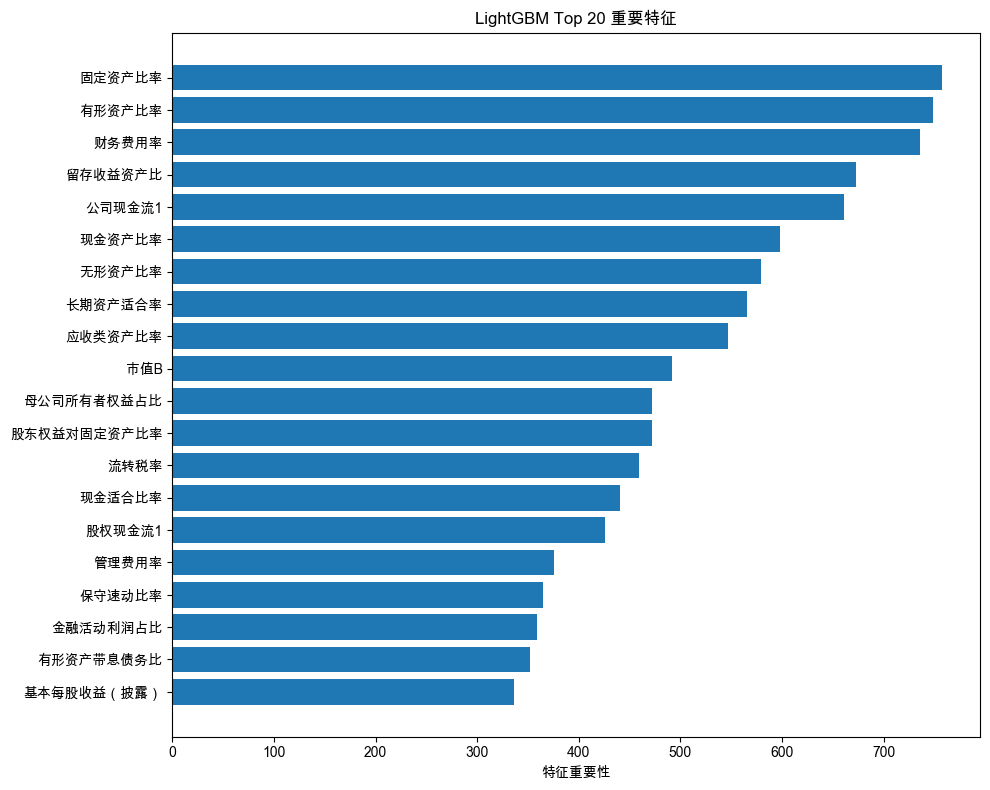

In [16]:
# 特征重要性分析
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']  # 支持中文显示
plt.rcParams['axes.unicode_minus'] = False

feature_importance = pd.DataFrame({
    '特征': feature_cols,
    '重要性': best_model.feature_importances_
}).sort_values('重要性', ascending=False)

print("=" * 60)
print("Top 20 重要特征")
print("=" * 60)
print(feature_importance.head(20).to_string(index=False))

# 可视化Top 20特征
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['重要性'].values)
plt.yticks(range(len(top_features)), top_features['特征'].values)
plt.xlabel('特征重要性')
plt.title('LightGBM Top 20 重要特征')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# 保存最优模型
import joblib

model_save_path = "best_lightgbm_model.pkl"
joblib.dump(best_model, model_save_path)
print(f"最优模型已保存至: {model_save_path}")

# 保存特征重要性
feature_importance.to_csv("feature_importance.csv", index=False, encoding='utf-8-sig')
print("特征重要性已保存至: feature_importance.csv")

# 保存测试集预测结果
test_results = test_df[["证券代码", "证券简称", "年份", "是否舞弊"]].copy()
test_results['预测结果'] = y_test_pred
test_results['预测概率'] = y_test_proba
test_results.to_excel("test_predictions.xlsx", index=False)
print("测试集预测结果已保存至: test_predictions.xlsx")

# 调参建议

如果完整网格搜索时间过长，可以采用以下策略：

1. **分阶段调参**：先用粗粒度参数范围找到大致区域，再细化搜索
2. **使用RandomizedSearchCV**：随机搜索可以更快地探索参数空间
3. **减少参数组合**：先固定部分参数，逐步调整关键参数
4. **使用早停**：在LightGBM中启用early_stopping_rounds
5. **减少交叉验证折数**：可以从5折改为3折